# Muhammad Shamil Umar

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
import plotly as plotly
import plotly.io as plotly
import plotly.graph_objects as go
import plotly.express as px
import sqlite3

In [2]:
df = pd.read_csv(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.csv")
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-01,353.399994,360.589996,319.829987,329.079987,329.079987,3793250000
1,1990-02-01,329.079987,336.089996,322.100006,331.890015,331.890015,2961970000
2,1990-03-01,331.890015,344.489990,331.079987,339.940002,339.940002,3283280000


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date']).sort_index()
print(df.shape)
df.head(3)

(413, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1990-01-01,1990-01-01,353.399994,360.589996,319.829987,329.079987,329.079987,3793250000
1990-02-01,1990-02-01,329.079987,336.089996,322.100006,331.890015,331.890015,2961970000
1990-03-01,1990-03-01,331.890015,344.489990,331.079987,339.940002,339.940002,3283280000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413 entries, 1990-01-01 to 2024-05-01
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       413 non-null    datetime64[ns]
 1   Open       413 non-null    float64       
 2   High       413 non-null    float64       
 3   Low        413 non-null    float64       
 4   Close      413 non-null    float64       
 5   Adj Close  413 non-null    float64       
 6   Volume     413 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 25.8 KB


We will be working on forcasting closing price of S&P stocks

c:\Users\shami\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


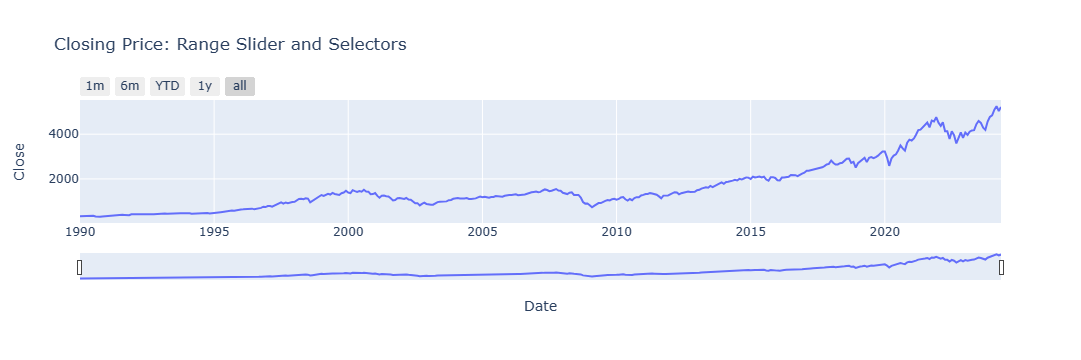

In [6]:
fig = px.line(df,x="Date",y="Close",title="Closing Price: Range Slider and Selectors")
fig.update_xaxes(rangeslider_visible=True,rangeselector=dict(
    buttons=list([
        dict(count=1,label="1m",step="month",stepmode="backward"),
        dict(count=6,label="6m",step="month",stepmode="backward"),
        dict(count=1,label="YTD",step="year",stepmode="todate"),
        dict(count=1,label="1y",step="year",stepmode="backward"),
        dict(step="all")
])))

In [5]:
monthly = df[['Close']].copy(deep=True)
monthly.head(5)

,Close
Date,
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
1990-05-01,361.230011


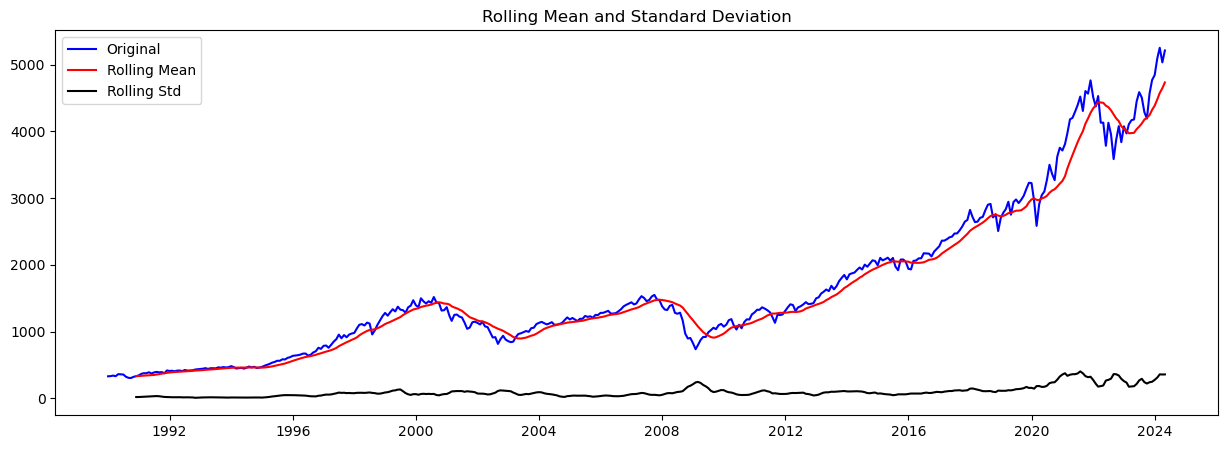

Results of dickey fuller test
Test Statistics                  2.298389
p-value                          0.998954
No. of lags used                16.000000
Number of observations used    396.000000
dtype: float64


In [12]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    plt.plot(timeseries,color='blue',label='Original')
    plt.plot(rolmean,color='red',label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    print(output)

test_stationarity(df['Close'])

In [13]:
def adfuller_test(sales):
    result=adfuller(sales,autolag='AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [14]:
adfuller_test(monthly['Close'])

ADF Test Statistic : 2.298388623413756
p-value : 0.998954157027155
#Lags Used : 16
Number of Observations Used : 396
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [331]:
x = pmdarima.utils.diff(monthly['Close'])
x = np.insert(x, 0, None)
monthly['First_Diff'] = x
monthly = monthly.dropna()

In [332]:
adfuller_test(monthly['First_Diff'])

ADF Test Statistic : -4.304641878678306
p-value : 0.0004360619536025447
#Lags Used : 15
Number of Observations Used : 394
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Text(0.5, 1.0, 'First Difference against time')

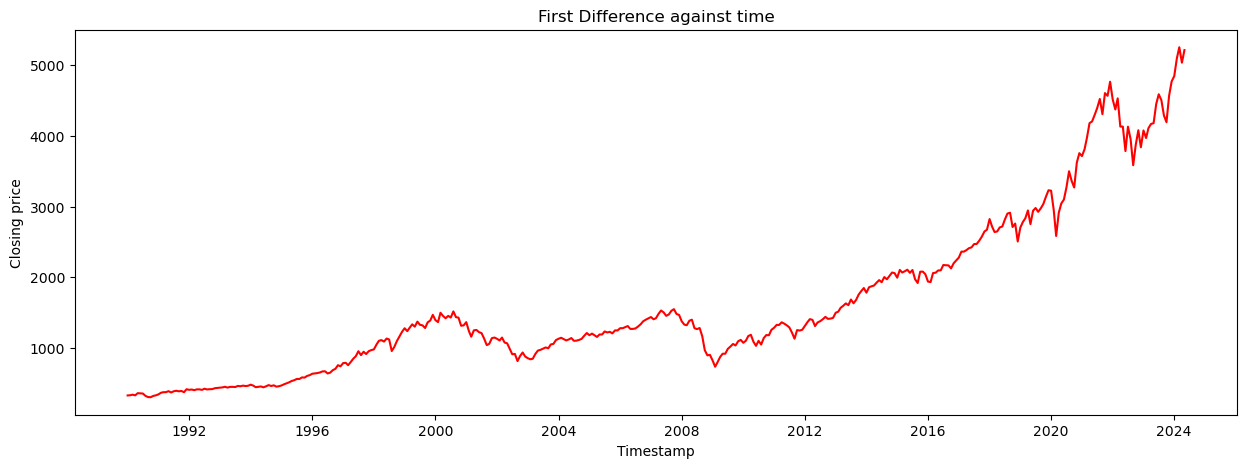

In [344]:
fig = plt.figure(figsize=(15, 5))
plt.plot(monthly.index,monthly['Close'],color='red')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.title('First Difference against time')

# Parameter Selection for ARIMA

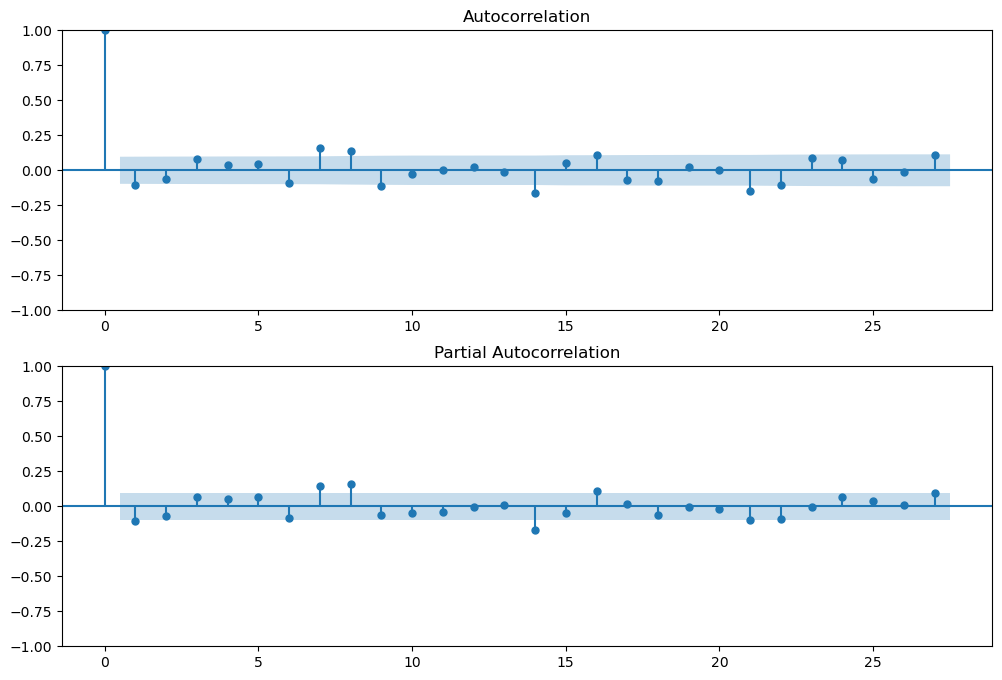

In [335]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly['First_Diff'],ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly['First_Diff'],ax=ax2)

In [6]:
train = monthly[:320]
test = monthly[320:]
print(len(test))

93


In [18]:
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
train.to_sql('Training', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
test.to_sql('Testing', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

In [56]:
from tqdm import tqdm
train_ar_m = train['Close'].values
test_ar_m = test['Close'].values
history = [x for x in train_ar_m]
print(type(history))
predictions_m = list()
for t in tqdm(range(len(test_ar_m))):
    model = ARIMA(history, order=(5,1,0))
    arima_fit = model.fit()
    output = arima_fit.forecast()
    yhat = output[0]
    predictions_m.append(yhat)
    obs = test_ar_m[t]
    history.append(obs)
    history.pop(0)
print('Monthly Basis Forecasting Perfomance')

<class 'list'>


100%|██████████| 93/93 [00:57<00:00,  1.61it/s]

Monthly Basis Forecasting Perfomance


In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(test_ar_m, predictions_m)
print('Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar_m, predictions_m)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error2)
error3=mean_absolute_percentage_error(test_ar_m, predictions_m)
print('Mean Absolute Percenatage Error:%.3f'%error3)
R2Score= r2_score(test_ar_m, predictions_m)
print('R2-Score:%.3f'% R2Score)

Mean Squared Error: 31304.743
Symmetric Mean Absolute Percentage Error: 3.901
Mean Absolute Percenatage Error:3.892
R2-Score:0.957


In [24]:
temp_arima = pd.DataFrame({'Timestamp': test.index, 'Predicted': predictions_m})
temp_arima.head(5)

,Timestamp,Predicted
0,2016-09-01,2169.180753
1,2016-10-01,2178.658387
2,2016-11-01,2129.537610
3,2016-12-01,2211.159488
4,2017-01-01,2231.567807


### Using arima for next 3 years of predictions

In [57]:
from tqdm import tqdm
new_history = [x for x in history]
predictions_m = list()
for t in tqdm(range(36)):
    model = ARIMA(new_history, order=(5,1,0))
    test = model.fit()
    output = test.forecast()
    yhat = output[0]
    predictions_m.append(yhat)
    new_history.append(yhat)
    new_history.pop(0)
print('Monthly Basis Forecasting Perfomance')

100%|██████████| 36/36 [00:24<00:00,  1.49it/s]

Monthly Basis Forecasting Perfomance


Text(0.5, 1.0, 'With Slicing')

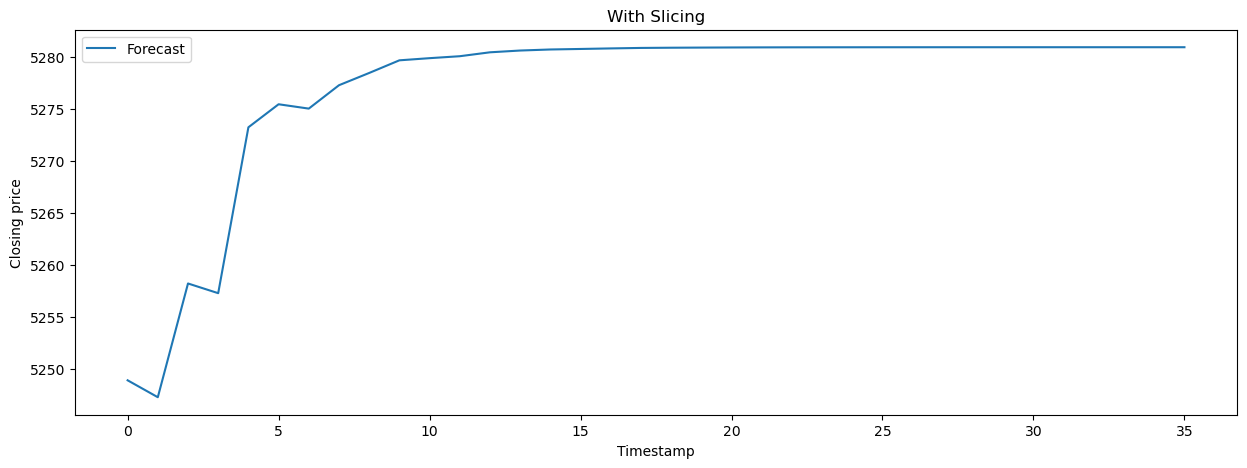

In [58]:
x = []
for i in range(36):
    x.append(i)
fig = plt.figure(figsize=(15, 5))
plt.plot(x,predictions_m,label='Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.legend()
plt.title('With Slicing')

In [64]:
df.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2024-05-01,2024-05-01,5029.029785,5215.299805,5011.049805,5214.080078,5214.080078,28091430000


In [65]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

start_date = datetime(2024, 6, 1)
end_date = start_date + relativedelta(months=+36)
monthly_dates = [start_date + relativedelta(months=+i) for i in range(0, 36)]
final = []
for date in monthly_dates:
    final.append(date.strftime('%Y-%m-%d'))
final

['2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01',
 '2025-01-01',
 '2025-02-01',
 '2025-03-01',
 '2025-04-01',
 '2025-05-01',
 '2025-06-01',
 '2025-07-01',
 '2025-08-01',
 '2025-09-01',
 '2025-10-01',
 '2025-11-01',
 '2025-12-01',
 '2026-01-01',
 '2026-02-01',
 '2026-03-01',
 '2026-04-01',
 '2026-05-01',
 '2026-06-01',
 '2026-07-01',
 '2026-08-01',
 '2026-09-01',
 '2026-10-01',
 '2026-11-01',
 '2026-12-01',
 '2027-01-01',
 '2027-02-01',
 '2027-03-01',
 '2027-04-01',
 '2027-05-01']

In [67]:
further_arima = pd.DataFrame({'Timestamp': final, 'Predicted': predictions_m})
further_arima.head(5)

,Timestamp,Predicted
0,2024-06-01,5248.870974
1,2024-07-01,5247.242111
2,2024-08-01,5258.194252
3,2024-09-01,5257.259937
4,2024-10-01,5273.233584


In [68]:
result = pd.concat([temp_arima,further_arima])
result.shape

(129, 2)

In [70]:
result['Timestamp'] = pd.to_datetime(result['Timestamp'])
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 0 to 35
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  129 non-null    datetime64[ns]
 1   Predicted  129 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


Text(0.5, 1.0, 'ARIMA Model')

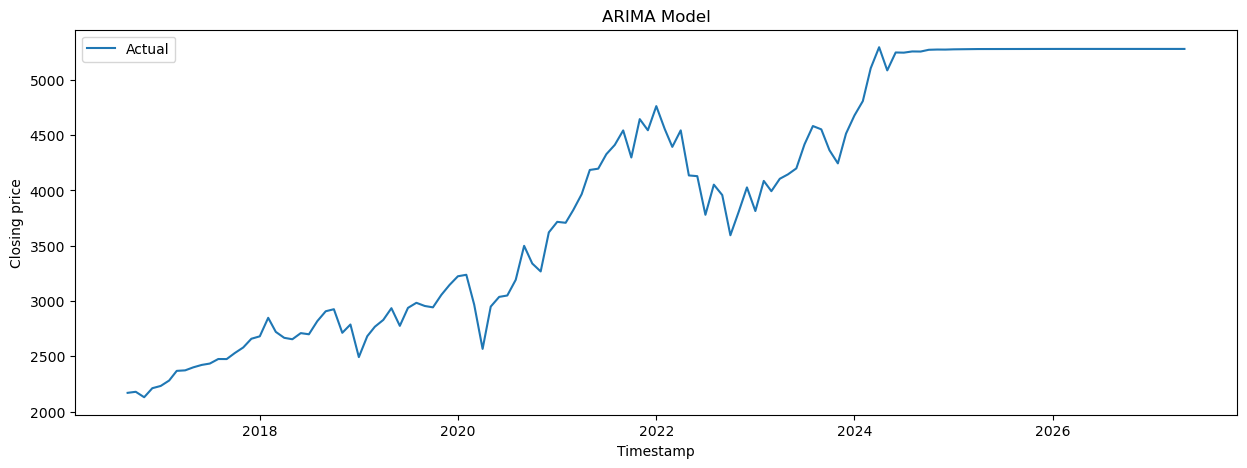

In [71]:
fig = plt.figure(figsize=(15, 5))
plt.plot(result['Timestamp'],result['Predicted'],label='Actual')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.legend()
plt.title('ARIMA Model')

In [72]:
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
result.to_sql('Arima_Prediction', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

Text(0.5, 1.0, 'ARIMA Model')

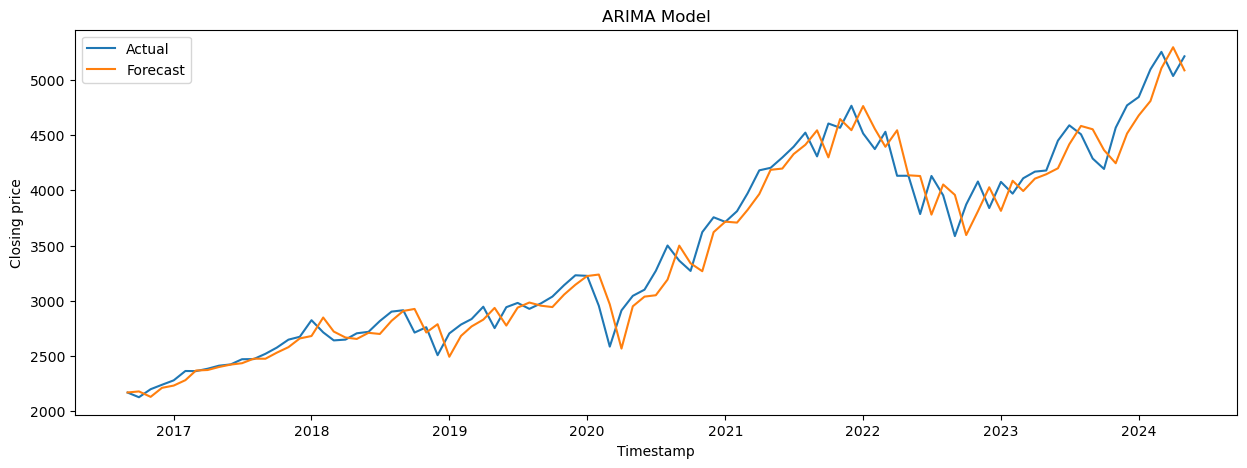

In [23]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test.index,test['Close'],label='Actual')
plt.plot(test.index,predictions_m,label='Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.legend()
plt.title('ARIMA Model')

# SARIMA

In [8]:
from tqdm import tqdm
train_sar_m = train['Close'].values
test_sar_m = test['Close'].values
history = [x for x in train_sar_m]
predictions_sm = list()
for t in tqdm(range(len(test_sar_m))):
    model = sm.tsa.statespace.SARIMAX(history,order=(5, 1, 0),seasonal_order=(5, 1, 0, 7))
    sarima_fit = model.fit()
    output = sarima_fit.forecast()
    yhat = output[0]
    predictions_sm.append(yhat)
    obs = test_sar_m[t]
    history.append(obs)
    history.pop(0)
print('Monthly Basis Forecasting Perfomance using Sarima')

100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [04:47<00:00,  3.09s/it]

Monthly Basis Forecasting Perfomance using Sarima


Text(0.5, 1.0, 'SARIMA Model')

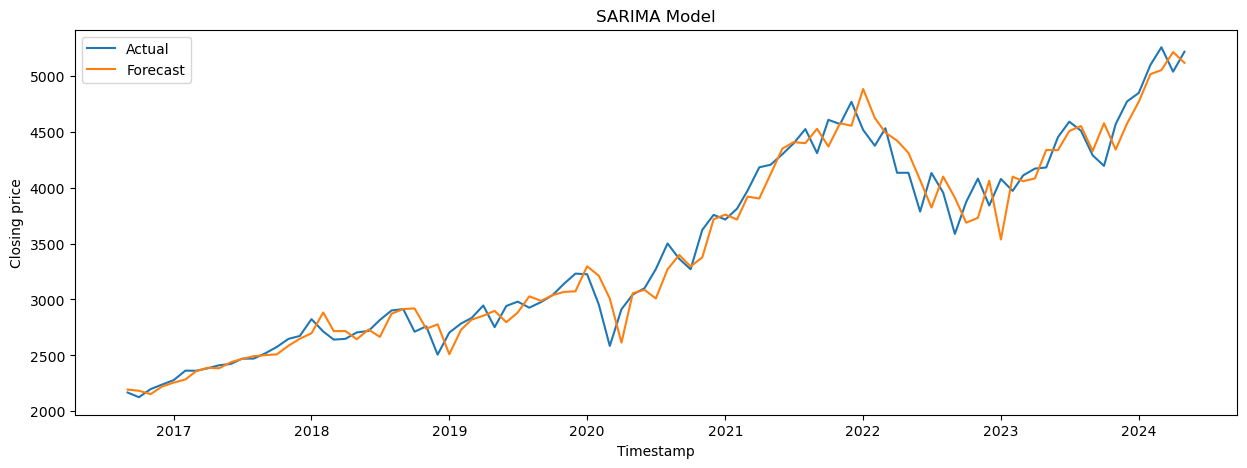

In [9]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test.index,test['Close'],label='Actual')
plt.plot(test.index,predictions_sm,label='Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Closing price')
plt.legend()
plt.title('SARIMA Model')

In [13]:
len(history)

320

In [14]:
from tqdm import tqdm
predictions_sm = list()
for t in tqdm(range(36)):
    model = sm.tsa.statespace.SARIMAX(history,order=(5, 1, 0),seasonal_order=(5, 1, 0, 7))
    sarima_fit = model.fit()
    output = sarima_fit.forecast()
    yhat = output[0]
    predictions_sm.append(yhat)
    history.append(yhat)
    history.pop(0)
print('Monthly Basis Forecasting Perfomance using Sarima')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [01:05<00:00,  1.83s/it]

Monthly Basis Forecasting Perfomance using Sarima


In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(test_sar_m, predictions_sm)
print('Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_sar_m, predictions_sm)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error2)
error3=mean_absolute_percentage_error(test_sar_m, predictions_sm)
print('Mean Absolute Percenatage Error:%.3f'%error3)
R2Score= r2_score(test_sar_m, predictions_sm)
print('R2-Score:%.3f'% R2Score)

Mean Squared Error: 28772.813
Symmetric Mean Absolute Percentage Error: 3.562
Mean Absolute Percenatage Error:3.564
R2-Score:0.961


# Saving Arima and Sarima models

In [374]:
import pickle
with open(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\arima.pkl", 'wb') as f:
    pickle.dump(arima_fit, f)

with open(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\sarima.pkl", 'wb') as f:
    pickle.dump(sarima_fit, f)

In [12]:
temp_sarima = pd.DataFrame({'Timestamp': test.index, 'Predicted': predictions_sm})
temp_sarima.head(5)

,Timestamp,Predicted
0,2016-09-01,2194.612782
1,2016-10-01,2183.858005
2,2016-11-01,2153.779633
3,2016-12-01,2221.210387
4,2017-01-01,2256.522954


In [15]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

start_date = datetime(2024, 6, 1)
end_date = start_date + relativedelta(months=+36)
monthly_dates = [start_date + relativedelta(months=+i) for i in range(0, 36)]
final = []
for date in monthly_dates:
    final.append(date.strftime('%Y-%m-%d'))

In [16]:
further_sarima = pd.DataFrame({'Timestamp': final, 'Predicted': predictions_sm})
further_sarima.head(5)

,Timestamp,Predicted
0,2024-06-01,5390.148867
1,2024-07-01,5480.326852
2,2024-08-01,5434.972139
3,2024-09-01,5647.768112
4,2024-10-01,5737.780918


In [17]:
result = pd.concat([temp_sarima,further_sarima])
result['Timestamp'] = pd.to_datetime(result['Timestamp'])
result

,Timestamp,Predicted
0,2016-09-01,2194.612782
1,2016-10-01,2183.858005
2,2016-11-01,2153.779633
3,2016-12-01,2221.210387
4,2017-01-01,2256.522954
...,...,...
31,2027-01-01,6338.510554
32,2027-02-01,6382.090752
33,2027-03-01,6212.864903
34,2027-04-01,6241.741404


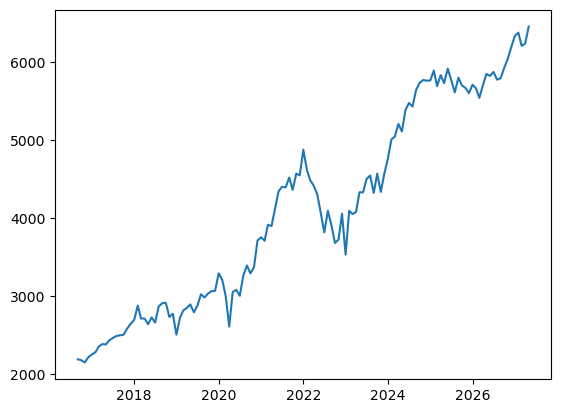

In [18]:
plt.plot(result['Timestamp'],result['Predicted'])

In [19]:
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
result.to_sql('Sarima_Prediction', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

In [20]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Execute a query to get the names of all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all rows from the result set
tables = cursor.fetchall()

# Extract table names from the result set
table_names = [table[0] for table in tables]

# Print the names of all tables
print("Tables in the database:")
for table_name in table_names:
    print(table_name)

# Close the cursor and connection
cursor.close()
conn.close()


Tables in the database:
Training
Testing
Arima_Prediction
Sarima_Prediction
